### 1. Separate analysis for each band
Especially for band 2 which shows the higest delinear relationship between the Sentinel TOA ref and the MODIS BRDF values. (brute force results 14	86.1	27.5	-5	9)


In [1]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
import matplotlib.patches as patches
from geo_trans import *
%matplotlib inline

In [2]:
cm = parallel_rw_pkl(None, '0510diacm', 'r')

In [3]:
patches = np.array(zip(np.mgrid[0:10,0:10][0].ravel(), np.mgrid[0:10,0:10][1].ravel()))
cprop = []
for i,j in patches:
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    prop = (cm[s1,s2]).sum()/(1000.*1000.)
    cprop.append([i,j,prop])

In [4]:
pacm = np.zeros((10,10))
cprop = np.array(cprop).T
pacm[cprop[0].astype(int), cprop[1].astype(int)] = cprop[2]

In [5]:
mc = []
for i in (np.sort(pacm.ravel())[:10]):
    mc.append(np.where(pacm == i))
mc = np.array(mc).reshape(10,2).T

In [7]:
x,y = mc
print zip(x,y)

[(2, 4), (9, 6), (9, 2), (1, 4), (0, 1), (2, 9), (4, 8), (3, 9), (9, 5), (1, 3)]


In [ ]:
fhead = 'data/50SMG20165100'
data = parallel_rw_pkl(None, 'inter_sent%i'%2, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%2, 'r')
fhead = 'data/50SMG20165100'
Sent = readfile([4,],fhead)['B04']
cm = parallel_rw_pkl(None, '0510diacm', 'r')
Sent[cm] = np.nan
print 'finshed reading data'
data[mask]=np.nan
modis_sent = np.array(data)

Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex

In [21]:
solves = []
fnames = ['patchb2_modis','patchb3_modis','patchb4_modis',
         'patchb8_modis','patchb8a_modis', 'patchb11_modis','patchb12_modis']
for i in fnames:
    data = parallel_rw_pkl(None, i, 'r')
    solve = []
    for i in data:
        for j in i:
            solve.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
    solves.append(solve)
solves = np.array(solves)

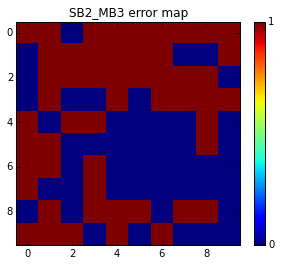

In [29]:
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
j = solves[0].T
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
zeros = np.zeros((10,10))
zeros[(j[0]).astype(int), (j[1]).astype(int)] = j[-1]
zeros = zeros<=0.5
cx = ax.imshow(zeros, interpolation ='Nearest')
fig.colorbar(cx,ticks=[0,1])
ax.set_title('SB2_MB3 error map')

In [39]:
x,y = np.where(zeros)
print zip(x,y)

[(0, 0), (0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 9), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 1), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 2), (4, 3), (4, 8), (5, 0), (5, 1), (5, 8), (6, 0), (6, 1), (6, 3), (7, 0), (7, 3), (8, 1), (8, 3), (8, 4), (8, 5), (8, 7), (8, 8), (9, 0), (9, 1), (9, 2), (9, 4), (9, 6)]


In [59]:
cf = []
for i in np.array([i for i in parallel_rw_pkl(None, 'clfreeb2_modis', 'r')]):
    cf+=i

In [64]:
cf = cf.T

LinregressResult(slope=0.95698028607262398, intercept=-0.094567480727054828, rvalue=0.78469691715241041, pvalue=0.0, stderr=0.0053529277982277291)


/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:324: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = np.fmax.reduce(a, axis=axis, out=out, keepdims=keepdims)


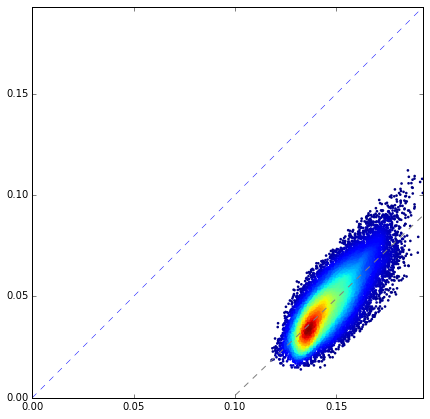

In [65]:
nanm = np.isnan(cf[0]) | np.isnan(cf[1])
y,x = cf[0][~nanm], cf[1][~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

Compared to the previous results, we can see a big improvement on the results, especially the slop, while a 0.6 improvement on the r value is also considered a good indication on the improvement of the results. Therefore a way that define a threshold for the proportion of cloud pixels in the small patch should can be used to remove those patches strongly influenced by the clouds.

In [66]:
# read in the cloud mask, which is dialated
cm = parallel_rw_pkl(None, '0510diacm', 'r')

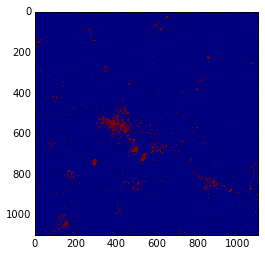

In [67]:
plt.imshow(cm[::10,::10])

In [73]:
patches = np.array(zip(np.mgrid[0:10,0:10][0].ravel(), np.mgrid[0:10,0:10][1].ravel()))
cprop = []
for i,j in patches:
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    prop = (cm[s1,s2]).sum()/(1000.*1000.)
    cprop.append([i,j,prop])

In [75]:
cprop = np.array(cprop).T

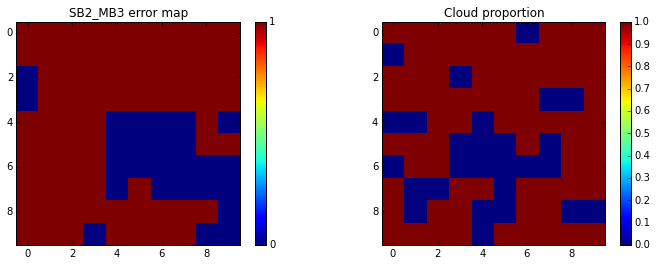

In [162]:
j = solves[0].T
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
zeros = np.zeros((10,10))
zeros[(j[0]).astype(int), (j[1]).astype(int)] = j[-1]
zeros = zeros<=0.8
cx = ax.imshow(zeros, interpolation ='Nearest', vmin=0, vmax = 1)
fig.colorbar(cx,ticks=[0,1])
ax.set_title('SB2_MB3 error map')
j=cprop
ax = fig.add_subplot(1,2,2)
zeros = np.zeros((10,10))
zeros[(j[0]).astype(int), (j[1]).astype(int)] = j[-1]
zeros = zeros<0.02
cx = ax.imshow(zeros, interpolation ='Nearest')
fig.colorbar(cx)
ax.set_title('Cloud proportion')

In [163]:
x,y = np.where(zeros)
print zip(x,y)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (0, 9), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 9), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 6), (5, 8), (5, 9), (6, 1), (6, 2), (6, 8), (6, 9), (7, 0), (7, 3), (7, 4), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 2), (8, 3), (8, 6), (8, 7), (9, 0), (9, 1), (9, 2), (9, 3), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


Here we set the threshold of cloud probability of 0.002 to remove those patches affected by the clouds, though it seams 2% cloud is too harsh, but actually, from the previous results, we can see the cloud has a way influence on the correlation between those two results. It seems the cloud mask is not totally related to the patchs with highest errors, this may be because of mislocation between the cloud and the area that it affected (particularly the cloud shadow), or because of the cloud type, which maybe have different influences on the reflectance.

In [176]:
b4_modis = parallel_rw_pkl(None, 'clfreeb4_modis', 'r')
b2_modis = parallel_rw_pkl(None, 'clfreeb2_modis', 'r')
b3_modis = parallel_rw_pkl(None, 'clfreeb3_modis', 'r')
b8_modis = parallel_rw_pkl(None, 'clfreeb8_modis', 'r')
b8a_modis = parallel_rw_pkl(None, 'clfreeb8a_modis', 'r')
b11_modis = parallel_rw_pkl(None, 'clfreeb11_modis', 'r')
b12_modis = parallel_rw_pkl(None, 'clfreeb12_modis', 'r')

In [177]:
bands = []
for j in [b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis]:
    
    data = []
    for i in j:
        data+=i
    bands.append(data)
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')

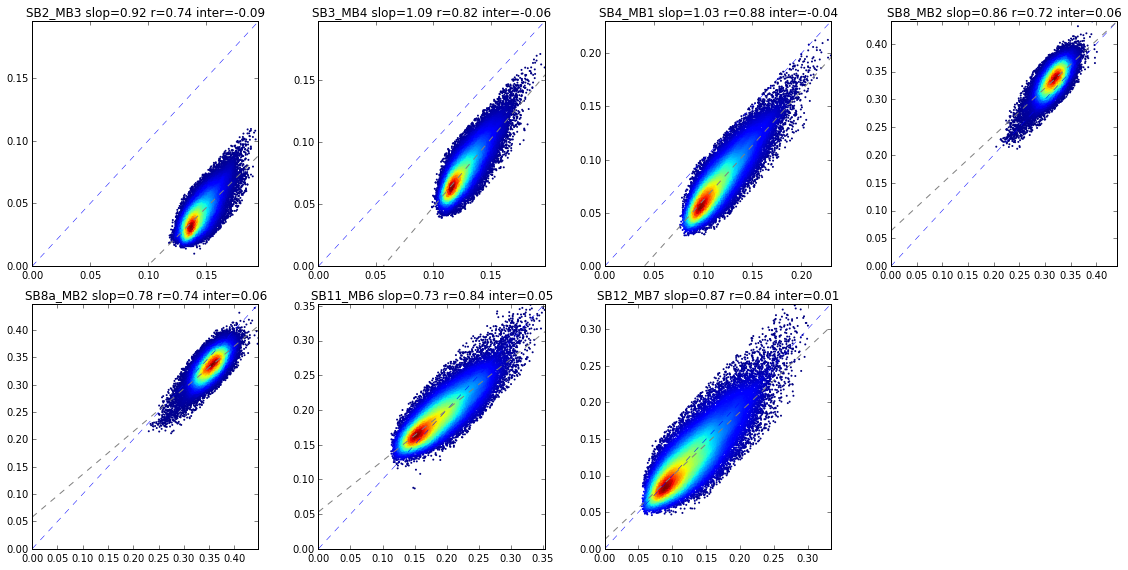

In [178]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()

Interestingly, band8 nearinfrared has a totally different response compared to the other bands. It seems the shorter wavelength, the bigger improvement on the results. For the band8 and band8a, the effects maybe from the water vapor?

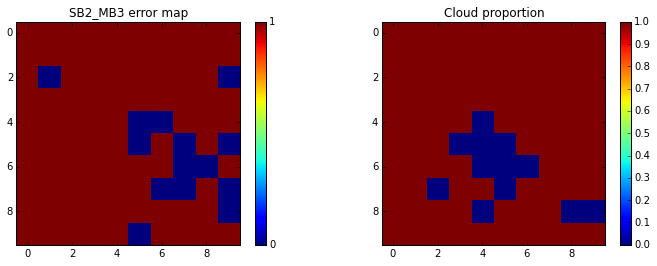

In [172]:
j = solves[3].T
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
zeros = np.zeros((10,10))
zeros[(j[0]).astype(int), (j[1]).astype(int)] = j[-1]
zeros = zeros<=0.8
cx = ax.imshow(zeros, interpolation ='Nearest', vmin=0, vmax = 1)
fig.colorbar(cx,ticks=[0,1])
ax.set_title('SB2_MB3 error map')
j=cprop
ax = fig.add_subplot(1,2,2)
zeros = np.zeros((10,10))
zeros[(j[0]).astype(int), (j[1]).astype(int)] = j[-1]
zeros = zeros<0.05
cx = ax.imshow(zeros, interpolation ='Nearest')
fig.colorbar(cx)
ax.set_title('Cloud proportion')

####  Solve only for those patches without the effects from the cloud.

In [50]:
solves = []
fnames = ['patb2_modis','patb3_modis','patb4_modis',
         'patb8_modis','patb8a_modis', 'patb11_modis','patb12_modis']
for i in fnames:
    data = parallel_rw_pkl(None, i, 'r')
    solve = []
    for i in data:
        for j in i:
            solve.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
    solves.append(solve)
solves = np.array(solves)

In [51]:
solves.shape

(7, 88, 6)

110.40373741
215.841003406
42.5914383343


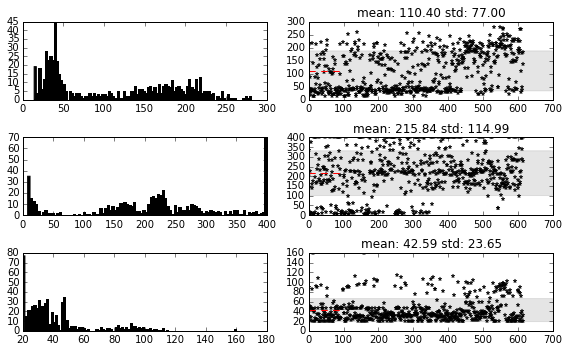

In [55]:
fig = plt.figure(figsize = (8,8))
x = solves.reshape(616, 6).T
for i,j in enumerate(x[2:-1, :]):
    s = i*2
    
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 100, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*', markersize=4)
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(700), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()

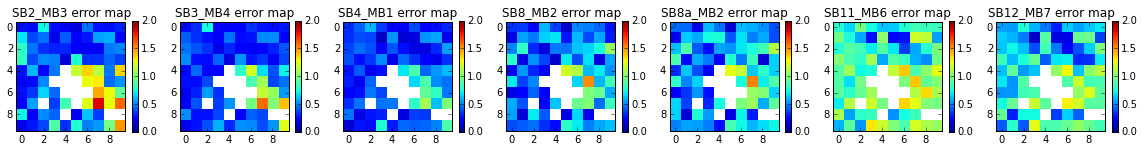

In [56]:
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
fig = plt.figure(figsize=(20,2))
for i,j in enumerate(solves):
    j = j.T
    ax = fig.add_subplot(1,7,i+1)
    zeros = np.zeros((10,10))
    zeros[:]=np.nan
    zeros[(j[0]).astype(int), (j[1]).astype(int)] = j[-1]
    cx = ax.imshow(zeros, interpolation ='Nearest', vmin=0, vmax=2)
    fig.colorbar(cx,ticks=[0.,0.5,1.,1.5,2.])
    ax.set_title('%s error map'%(names[i]))